## Intro

This notebook runs the negative correlation algorithm for squared loss through pytorch, and measure the diversity

In [1]:
# # # local
project_directory = "../"


# # # # colab
# from google.colab import drive
# drive.mount('/content/drive')
# project_directory = "/content/drive/MyDrive/colab_working_directory/diversity-enforced-ensembles/"
# !pip install cached-property

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# allow import of decompose locally
import sys
sys.path.append(project_directory + 'src/')

from decompose import SquaredLoss
import bvdlib
import ml_utils
from ml_utils.torch_data_utils import minimal_implementation_dataset
from ml_utils.ensemble_utils import SimpleMLP
from ml_utils.ensemble_utils import Ensemble_Runner
from ml_utils.ensemble_utils import torch_MSE_combiner

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
save_path_without_extension = project_directory + "experiments/results/stepbased_NCL_Regression_CaliforniaHousing_small"

## Pre-Process Data

In [4]:
# get data

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

x = housing['data']
y = housing['target']

print("x shape", x.shape)
print("y shape", y.shape)

x shape (20640, 8)
y shape (20640,)


In [5]:
#define settings

n_trials = 75
data_percentage_training = int(0.8 * len(y))
num_training =  int(0.8 * data_percentage_training) # percent of data for each trial from training
trial_space = np.arange(0,7, 0.5) / 10
print(trial_space)

learning_rate = 0.06
take_steps_rather_than_epoch = True
consider_epoch_every_x_steps = 5

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65]


In [6]:
# seed experiment
experiment_seed = 0
np.random.seed(experiment_seed)
torch_generator = torch.manual_seed(experiment_seed)
# split and preprocess data,
rng = np.random.default_rng()
shuffled_indices = rng.permutation(len(y))


x = x.astype(float)
y = y.astype(float)
train_indices = shuffled_indices[:data_percentage_training]
test_indices = shuffled_indices[data_percentage_training:]
train_data = x[train_indices, :]
train_labels = y[train_indices]
test_data = x[test_indices, :]
test_labels = y[test_indices]

In [7]:
decomp_fn = SquaredLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = torch.nn.MSELoss()
test_dset = minimal_implementation_dataset(test_data, test_labels, device)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size = len(test_dset), shuffle=False)
chosen_model = SimpleMLP
combiner_rule = torch_MSE_combiner

parameter_dictionary = {
    "epoch_n": 20,
    "estimator_n": 11,
    "batch_size" : 128,
    "hidden_size" : 8,
    "hidden_layer_num" : 2,
    "device" : device,
    "combiner_rule" : combiner_rule,
    "criterion" : criterion,
}



In [8]:
# with estim 10 lambda upper = m**2 / (2((m-1)**2) = 0.605 for estim (m) = 11

## Run Experiments

In [9]:
# define a trial
def trial_run(trial):
  

  #setup trial
  params = trial.get_params
  trial_estimators = params['estimator_n']
  epoch_results = []
  epoch_ens_train_losses = []
  epoch_ens_test_losses = []
  epoch_member_train_losses = []
  epoch_member_test_losses = []

  trial_x, trial_y = trial.get_data
  trial_dset = minimal_implementation_dataset(trial_x, trial_y, params['device'])
  trial_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = params['batch_size'], shuffle=True, generator=torch_generator)
  # trial_unshuffled_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = len(trial_dset), shuffle=False)

  trial_criterion = params['criterion']
  # init model
  ensemble = []
  optims = []
  losses = []

  
  for member_n in range(trial_estimators):
      ensemble.append(SimpleMLP(len(trial_x[0]), 1, params['hidden_size'], params['hidden_layer_num'], torch_generator).to(params['device']))
      optims.append(torch.optim.SGD(ensemble[member_n].parameters(), lr=learning_rate, momentum=0.9))
      losses.append(None)
      
  ens_runner = Ensemble_Runner(ensemble[0], params['combiner_rule'])
  lambda_ = params['lambda']

  overall_trial_stepcount = 0


  #run training
  for epoch in range(params['epoch_n']):
     
    trial_results_array = np.zeros((trial_estimators, len(test_data)))

    for batch_idx, (batch_x, batch_y) in enumerate(trial_dloader):
      # get detached ensemble output

      if take_steps_rather_than_epoch:
        
        if overall_trial_stepcount % consider_epoch_every_x_steps == 0:
          
          # print(overall_trial_stepcount, batch_idx)
          member_test_losses = np.zeros((trial_estimators))
          member_train_losses = np.zeros((trial_estimators))
          with torch.no_grad():
              trial_x_to_runnable = torch.tensor(trial_x).type(torch.float).to(params['device'])
              trial_y_to_runnable = torch.tensor(trial_y).unsqueeze(dim=-1).type(torch.float).to(params['device'])
              test_x_to_runnable = torch.tensor(test_data).type(torch.float).to(params['device'])
              test_y_to_ens_runnable = torch.tensor(test_labels).unsqueeze(dim=-1).type(torch.float).to(params['device'])
              trial_ensemble_output, trial_member_output = ens_runner.forward(trial_x_to_runnable, ensemble)
              test_ensemble_output, test_member_output = ens_runner.forward(test_x_to_runnable, ensemble)
              epoch_ens_train_losses.append(trial_criterion(trial_ensemble_output, trial_y_to_runnable).cpu())
              epoch_ens_test_losses.append(trial_criterion(test_ensemble_output, test_y_to_ens_runnable).cpu())
              trial_results_array = np.array(test_member_output.cpu().squeeze())
              for i in range(trial_estimators):
                # print(test_y_to_ens_runnable.size())
                member_test_losses[i] = trial_criterion(test_member_output[i], test_y_to_ens_runnable).cpu()
                member_train_losses[i] = trial_criterion(trial_member_output[i], trial_y_to_runnable).cpu()

          epoch_results.append(np.array(trial_results_array))
          epoch_member_train_losses.append(np.sort(member_train_losses))
          epoch_member_test_losses.append(np.sort(member_test_losses))
      overall_trial_stepcount += 1
        
        

      with torch.no_grad():
        _, member_output = ens_runner.forward(batch_x, ensemble)
        
      # update each member
      for i, member in enumerate(ensemble):
        optims[i].zero_grad()
        member_pred = member(batch_x)
        member_grad_output = torch.cat((member_output[:i], member_pred.unsqueeze(dim=0), member_output[i+1:]))
        ens_grad_output = params['combiner_rule'](member_grad_output)
        losses[i] = ((0.5* trial_criterion(member_pred, batch_y.unsqueeze(dim=-1))) - ((lambda_) * trial_criterion(member_pred, ens_grad_output)))
        losses[i].backward()
        optims[i].step()
      # print(member_loss)
        
  #do inference
    if not take_steps_rather_than_epoch:
      member_test_losses = np.zeros((trial_estimators))
      member_train_losses = np.zeros((trial_estimators))
      with torch.no_grad():
          trial_x_to_runnable = torch.tensor(trial_x).type(torch.float).to(params['device'])
          trial_y_to_runnable = torch.tensor(trial_y).unsqueeze(dim=-1).type(torch.float).to(params['device'])
          test_x_to_runnable = torch.tensor(test_data).type(torch.float).to(params['device'])
          test_y_to_ens_runnable = torch.tensor(test_labels).unsqueeze(dim=-1).type(torch.float).to(params['device'])
          trial_ensemble_output, trial_member_output = ens_runner.forward(trial_x_to_runnable, ensemble)
          test_ensemble_output, test_member_output = ens_runner.forward(test_x_to_runnable, ensemble)
          epoch_ens_train_losses.append(trial_criterion(trial_ensemble_output, trial_y_to_runnable).cpu())
          epoch_ens_test_losses.append(trial_criterion(test_ensemble_output, test_y_to_ens_runnable).cpu())
          trial_results_array = np.array(test_member_output.cpu().squeeze())
          for i in range(trial_estimators):
            # print(test_y_to_ens_runnable.size())
            member_test_losses[i] = trial_criterion(test_member_output[i], test_y_to_ens_runnable).cpu()
            member_train_losses[i] = trial_criterion(trial_member_output[i], trial_y_to_runnable).cpu()
          
        
      epoch_results.append(np.array(trial_results_array))
      epoch_member_train_losses.append(member_train_losses)
      epoch_member_test_losses.append(member_test_losses)
  
  return epoch_results, epoch_ens_train_losses, epoch_member_train_losses, epoch_member_test_losses, epoch_ens_test_losses

# save results
  
total_step_count_estimate = (parameter_dictionary['epoch_n'] * (num_training // parameter_dictionary['batch_size']))
results_objs = -(total_step_count_estimate // -consider_epoch_every_x_steps)+1 # ceiling divison plus 0 step result object
study = bvdlib.NCL_Study(trial_space, parameter_dictionary, train_data, train_labels, test_data, test_labels, 
                    num_training, n_trials, decomp_fn, num_results_objects=results_objs, estimator_n=parameter_dictionary['estimator_n'])

results = study.run_trials(trial_run)

if not os.path.exists(save_path_without_extension):
    os.makedirs(save_path_without_extension)

for epoch, result in enumerate(results):
  this_save_path = save_path_without_extension + "/stepmeasure_" + str(epoch) + ".pkl"
  result.save_results(this_save_path)

  0%|          | 0/14 [00:14<?, ?it/s]


KeyboardInterrupt: 

<Axes: xlabel='lambda'>

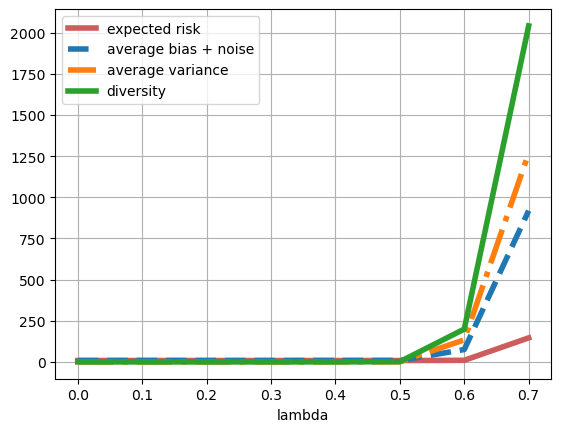

In [ ]:
from decompose.plotting_utils import plot_bvd
print(len(results))
results_idx = 25

ax = plot_bvd(results[results_idx])
# print(results[results_idx].diversity)
# print(results[results_idx].average_variance)
# ax.set_xlim(0,0.4)results[results_idx]